In [1]:
import rasterio
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import measure
import glob
from rasterio.merge import merge

In [2]:
from shapely.geometry import LineString, MultiPolygon, Polygon
from shapely.ops import unary_union
import  matplotlib.patches as patches

In [3]:
curr_path = os.getcwd()
print(curr_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks


In [4]:
tile_dir = os.path.join(curr_path, 'pred_mask_1_1152_7296')
print(tile_dir)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\pred_mask_1_1152_7296


In [106]:
file_names = os.listdir(tile_dir)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\pred_mask_24_1152_6144'

In [7]:
coord_dir = os.path.join(curr_path, 'Data\Coordinates')
print(coord_dir)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\Coordinates


In [4]:
tile_path = os.path.join(curr_path, 'pred_mask_1_1152_7296.tif')
print(tile_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\pred_mask_1_1152_7296.tif


In [8]:
coord_path = os.path.join(coord_dir, 'Coo_1_1152_7296_coo.txt')
print(coord_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\Coordinates\Coo_1_1152_7296_coo.txt


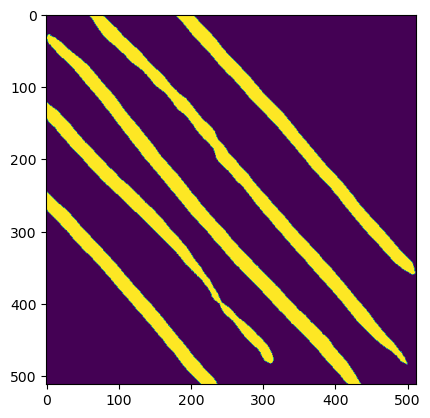

In [9]:
with rasterio.open(tile_path) as src:
    image = src.read(1)
    meta = src.meta
    transform = src.transform

plt.imshow(image)

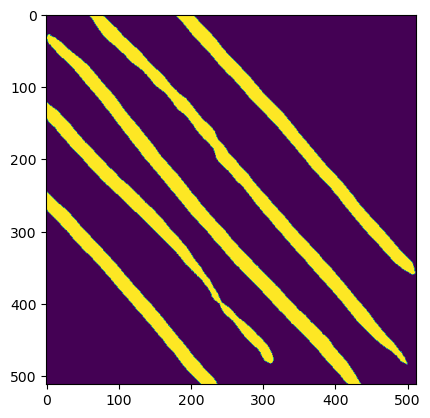

In [10]:
min_val = np.min(image)
max_val = np.max(image)

if max_val == min_val:
    # Handle the case where all values are the same (e.g., a constant image)
    tile_normalized = np.zeros_like(image, dtype=np.float32)
else:
    # Normalize to range [0, 1]
    tile_normalized = (image - min_val) / (max_val - min_val)

plt.imshow(tile_normalized)

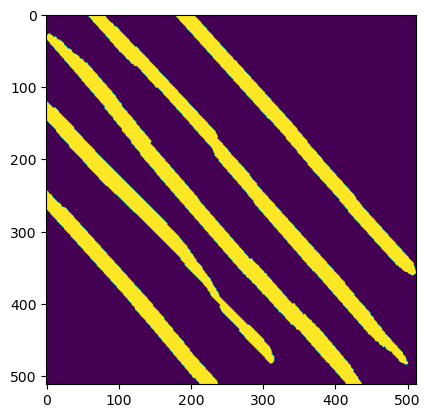

In [11]:
tile_uint8 = (tile_normalized * 255).astype(np.uint8)

tile_lines = cv2.HoughLinesP(tile_uint8, 1, np.pi / 180, threshold=50, minLineLength=10, maxLineGap=15)

blank_image = np.zeros((512, 512), dtype=np.uint8)

if tile_lines is not None:
    for line in tile_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(blank_image, (x1, y1), (x2, y2), 255, 2)  # White lines

plt.imshow(blank_image)

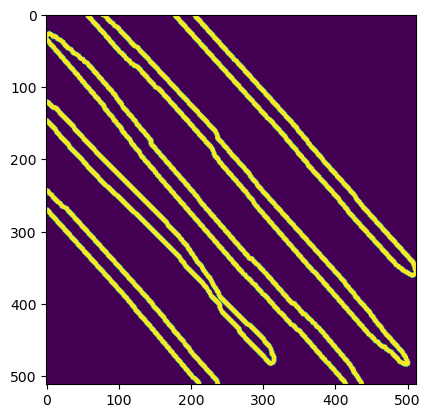

In [12]:
tile_edges = cv2.Canny(blank_image, threshold1=100, threshold2=200)

tile_contours, _ = cv2.findContours(tile_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

tile_lines = np.zeros_like(tile_uint8)
contour_image = cv2.drawContours(tile_lines, tile_contours, -1, (255, 255, 255), thickness=5)

plt.imshow(contour_image)

In [13]:
kernel = np.ones((15,15), np.uint8)

dilated_edges = cv2.dilate(contour_image, kernel, iterations=1)

binary_image = dilated_edges > 0

skeleton = skeletonize(binary_image)

labeled_skeleton, num_labels = measure.label(skeleton, return_num=True, connectivity=2)

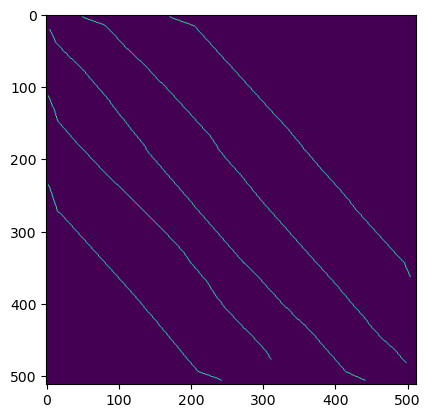

In [14]:
plt.imshow(skeleton)

In [15]:
# Your previous code for contour detection and dilation
kernel = np.ones((2 , 2), np.uint8)

# Plotting and saving the skeleton image as a PDF
skeleton_thick = cv2.dilate(skeleton.astype(np.uint8), kernel, iterations=1)  # Dilate to thicken

plt.figure(figsize=(8, 8))
plt.imshow(skeleton_thick, cmap='gray')
plt.axis('off')  # Hide axis
plt.savefig("skeleton_image.jpg", format="jpg", bbox_inches="tight", pad_inches=0)
plt.close()

In [16]:
print(labeled_skeleton)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [17]:
line_coordinates = []
    
for label in range(1, num_labels + 1):
    component_mask = (labeled_skeleton == label)
    endpoints = []

    # Loop through skeleton and find endpoints
    for y in range(1, component_mask.shape[0] - 1):
        for x in range(1, component_mask.shape[1] - 1):
            if component_mask[y, x]:
            # Check the 8-neighborhood
                neighbors = component_mask[y-1:y+2, x-1:x+2]
                if np.sum(neighbors) == 2:  # Exactly one neighbor means it's an endpoint
                    endpoints.append((x, y))

    if len(endpoints) == 2:
        start = endpoints[0]
        end = endpoints[1]
        line_coordinates.append([start[0], start[1], end[0], end[1]])

In [18]:
# Create a blank 512x512 image to draw the lines
output_image = np.zeros((512, 512), dtype=np.uint8)

# Draw each line on the blank image
for line in line_coordinates:
    x1, y1, x2, y2 = line
    cv2.line(output_image, (x1, y1), (x2, y2), color=255, thickness=2)  # Draw the line in white

In [19]:
print(line_coordinates)

[[50, 3, 498, 482], [171, 3, 504, 363], [5, 21, 441, 506], [3, 113, 311, 477], [3, 236, 242, 506]]


In [20]:
ground_truth_coord = []
    
with open(coord_path, 'r') as file:
    for line in file:
        line = line.strip()    
        coordinates = [float(x) for x in line.split(',')]    
        ground_truth_coord.append(coordinates)

In [21]:
print(line_coordinates)
print(ground_truth_coord)

[[50, 3, 498, 482], [171, 3, 504, 363], [5, 21, 441, 506], [3, 113, 311, 477], [3, 236, 242, 506]]
[[435.84810126582283, 0.0, 512.0, 107.42857142857156], [1.0, 9.0, 434.3148614609572, 512.0], [0.0, 240.85510009532845, 233.90707236842127, 512.0], [0.0, 106.403162055336, 343.4845188284519, 512.0], [0.0, 349.8254237288138, 137.27833572453346, 512.0], [512.0, 489.1059405940596, 88.69494430162808, 0.0], [206.2137404580153, 0.0, 512.0, 365.64097363083147], [0.0, 492.49844236760146, 16.873315363881375, 512.0]]


In [37]:
def plot_lines_and_buffer(ground_truth_lines, ground_truth_buffer, predicted_lines):
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot ground truth lines in blue
    for line in ground_truth_lines:
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=2, label='Ground Truth' if line == ground_truth_lines[0] else "")

    # Plot buffer, handling MultiPolygon or Polygon
    if isinstance(ground_truth_buffer, Polygon):
        # If it's a single Polygon, plot it directly
        buffer_patch = patches.Polygon(list(ground_truth_buffer.exterior.coords), closed=True, color='lightblue', alpha=0.5)
        ax.add_patch(buffer_patch)
    elif isinstance(ground_truth_buffer, MultiPolygon):
        # If it's a MultiPolygon, use the geoms attribute to access each polygon
        for poly in ground_truth_buffer.geoms:
            buffer_patch = patches.Polygon(list(poly.exterior.coords), closed=True, color='lightblue', alpha=0.5)
            ax.add_patch(buffer_patch)

    # Plot predicted lines in red
    for pred_line in predicted_lines:
        x, y = pred_line.xy
        ax.plot(x, y, color='red', linestyle='--', linewidth=2, label='Predicted' if pred_line == predicted_lines[0] else "")

    # Set labels and title
    ax.set_title('Predicted Skid trails overlayed on Ground Truth')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')

    plt.gca().invert_yaxis()
    # Save the plot
    plt.savefig("output_plot.jpg", format="jpg", dpi=300, bbox_inches="tight", pad_inches=0)
    #print(f"Plot saved to output_plot.jpg")

    # Close the plot to free memory
    plt.close(fig)

In [38]:
# Assuming ground_truth_coord is already available and in (x1, y1, x2, y2) format
ground_truth_lines = []
for coords in ground_truth_coord:
    line = LineString([(coords[0], coords[1]), (coords[2], coords[3])])
    ground_truth_lines.append(line)

# Create a union of all ground truth lines
ground_truth_union = unary_union(ground_truth_lines)

In [39]:
# Create buffer around the ground truth lines
buffer_distance = 15  # Adjust this as needed
ground_truth_buffer = ground_truth_union.buffer(buffer_distance)

In [40]:
# Create predicted lines as LineString objects
predicted_lines = []
for pred_coords in line_coordinates:
    pred_line = LineString([(pred_coords[0], pred_coords[1]), (pred_coords[2], pred_coords[3])])
    predicted_lines.append(pred_line)

In [41]:
plot_lines_and_buffer(ground_truth_lines, ground_truth_buffer, predicted_lines)

In [164]:
EA_List=[]
length_list = []

TP = 0
FP = 0
FN = 0

# List to keep track of predicted lines that have been matched
matched_predicted_lines = set()

In [165]:
for gt_line in ground_truth_lines:
    found_match = False
    for predicted_line in predicted_lines:
        if gt_line.buffer(buffer_distance).intersects(predicted_line):
            predicted_coords = list(predicted_line.coords)
            ground_truth_coords = list(gt_line.coords)

            predicted_flat = [coord for pair in predicted_coords for coord in pair]
            ground_flat = [coord for pair in ground_truth_coords for coord in pair]

            print(f"Matching ground truth line coordinates: {ground_flat}")
            print(f"Matching predicted truth line coordinates: {predicted_flat}")

            ground_line = Line(ground_flat)
            predicted_line = Line(predicted_flat)

            # Step 4: Call the metric function (e.g., calculate IoU or any other metric)
            # Assuming your metric function is called 'calculate_metric':
            EA = EA_metric(predicted_line, ground_line)  # Replace with actual function            
            EA_List.append(EA)

            LL = length_difference(predicted_line.coord, ground_line.coord)
            length_list.append(LL)

            matched_predicted_lines.add(predicted_line)
            found_match = True
            break

    if not found_match:
        FN += 1
        
for predicted_line in predicted_lines:
    # Check if the predicted line intersects with any ground truth line
    if not any(predicted_line.buffer(buffer_distance).intersects(gt_line) for gt_line in ground_truth_lines):
        # If the predicted line didn't intersect with any ground truth line, it's a False Positive
        FP += 1

# Step 3: Calculate the number of True Positives (TP) based on the matched predicted lines
TP = len(matched_predicted_lines)

# Output results
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

Matching ground truth line coordinates: [1.0, 9.0, 434.3148614609572, 512.0]
Matching predicted truth line coordinates: [5.0, 21.0, 441.0, 506.0]
Matching ground truth line coordinates: [0.0, 240.85510009532845, 233.90707236842127, 512.0]
Matching predicted truth line coordinates: [3.0, 236.0, 242.0, 506.0]
Matching ground truth line coordinates: [0.0, 106.403162055336, 343.4845188284519, 512.0]
Matching predicted truth line coordinates: [3.0, 113.0, 311.0, 477.0]
Matching ground truth line coordinates: [512.0, 489.1059405940596, 88.69494430162808, 0.0]
Matching predicted truth line coordinates: [50.0, 3.0, 498.0, 482.0]
Matching ground truth line coordinates: [206.2137404580153, 0.0, 512.0, 365.64097363083147]
Matching predicted truth line coordinates: [171.0, 3.0, 504.0, 363.0]
True Positives (TP): 5
False Positives (FP): 0
False Negatives (FN): 3


In [166]:
print(EA_List)
print(length_list)

[0.9501157106897679, 0.9542115319630285, 0.9211536788728012, 0.8558110949350312, 0.859938709804515]
[0.022778805431640316, 0.018282049977372563, 0.06443861573001915, 0.054728568554700215, 0.04737628058054431]


In [167]:
ea_avg = sum(EA_List)/len(EA_List)
print(ea_avg)

ll_avg = sum(length_list)/len(length_list)
print(ll_avg)

0.9082461452530287
0.041520864054855305


In [168]:
Precision = TP / (TP + FP)
print(Precision)
Recall = TP / (TP + FN)
print(Recall)

1.0
0.625


# Evaluation Metric

In [169]:
import numpy as np
import math
from scipy.optimize import linear_sum_assignment

In [170]:
class Line(object):
    def __init__(self, coordinates=[0, 0, 1, 1]):
        """
        coordinates: [y0, x0, y1, x1]

        """
        coordinates[0], coordinates[1] = coordinates[1], coordinates[0]
        coordinates[2], coordinates[3] = coordinates[3], coordinates[2]
        assert isinstance(coordinates, list)
        assert len(coordinates) == 4
        assert coordinates[0]!=coordinates[2] or coordinates[1]!=coordinates[3]
        self.__coordinates = coordinates

    @property
    def coord(self):
        return self.__coordinates

    @property
    def length(self):
        start = np.array(self.coord[:2])
        end = np.array(self.coord[2::])
        return np.sqrt(((start - end) ** 2).sum())

    def angle(self):
        y0, x0, y1, x1 = self.coord
        if x0 == x1:
            return -np.pi / 2
        return np.arctan((y0-y1) / (x0-x1))

    def rescale(self, rh, rw):
        coor = np.array(self.__coordinates)
        r = np.array([rh, rw, rh, rw])
        self.__coordinates = np.round(coor * r).astype(np.int).tolist()

    def __repr__(self):
        return str(self.coord)

In [171]:
def sa_metric(angle_p, angle_g):
    d_angle = np.abs(angle_p - angle_g)
    d_angle = min(d_angle, np.pi - d_angle)
    d_angle = d_angle * 2 / np.pi
    return max(0, (1 - d_angle)) ** 2

def se_metric(coord_p, coord_g, size=(512, 512)):
    c_p = [(coord_p[0] + coord_p[2]) / 2, (coord_p[1] + coord_p[3]) / 2]
    c_g = [(coord_g[0] + coord_g[2]) / 2, (coord_g[1] + coord_g[3]) / 2]
    d_coord = np.abs(c_p[0] - c_g[0])**2 + np.abs(c_p[1] - c_g[1])**2
    d_coord = np.sqrt(d_coord) / max(size[0], size[1])
    return max(0, (1 - d_coord)) ** 2
    
def EA_metric(l_pred, l_gt, size=(512, 512)):
    se = se_metric(l_pred.coord, l_gt.coord, size=size)
    sa = sa_metric(l_pred.angle(), l_gt.angle())
    return sa * se

In [172]:
def length_difference(p_coord, g_coord):
    p_y0, p_x0, p_y1, p_x1 = p_coord
    g_y0, g_x0, g_y1, g_x1 = g_coord

    norm_gt = np.sqrt(g_y0**2 + g_x0**2 + g_y1**2 + g_x1**2)
    norm_pd = np.sqrt(p_y0**2 + p_x0**2 + p_y1**2 + p_x1**2)

    norm_factor = np.sqrt(norm_gt**2 + norm_pd**2)

    dist1 = math.sqrt((g_x1 - p_x1) ** 2 + (g_y1 - p_y1) ** 2)
    dist2 = math.sqrt((g_x0 - p_x0) ** 2 + (g_y0 - p_y0) ** 2)
    diff1 = dist1 + dist2
    norm_diff1 = diff1 / norm_factor

    dist3 = math.sqrt((g_x1 - p_x0) ** 2 + (g_y1 - p_y0) ** 2)
    dist4 = math.sqrt((g_x0 - p_x1) ** 2 + (g_y0 - p_y1) ** 2)
    diff2 = dist3 + dist4
    norm_diff2 = diff2 / norm_factor

    len_diff = min(norm_diff1, norm_diff2)

    return len_diff

In [173]:
def build_graph(p_lines, g_lines, threshold):
    prediction_len = len(p_lines)
    gt_len = len(g_lines)
    G = np.zeros((prediction_len, gt_len))
    for i in range(prediction_len):
        for j in range(gt_len):
            if EA_metric(p_lines[i], g_lines[j]) >= threshold:
                G[i][j] = 1
    return G

In [174]:
def calculate_tp_fp_fn(b_points, gt_coords, thresh=0.90):
    p_lines = []
    g_lines = []
    for points in b_points:
        if len(points) == 0:
            continue 
        if points[0] == points[2] and points[1] == points[3]:
            continue 
        else:
            p_lines.append(Line(list(points)))
    
    for points in gt_coords:
        if len(points) == 0:
            continue
        if points[0] == points[2] and points[1] == points[3]:
            continue 
        else:
            g_lines.append(Line(list(points)))

    avg_length_difference = 0

    G = build_graph(p_lines, g_lines, thresh)

    row_ind, col_ind = linear_sum_assignment(-G)

    pair_nums = G[row_ind, col_ind].sum()

    tp = pair_nums
    fp = len(p_lines) - pair_nums
    fn = len(g_lines) - pair_nums

    length_differences = []
    for i, j in zip(row_ind, col_ind):  # Iterate over the matched indices
        if G[i, j] == 1:  # Ensure that this pair was actually matched
            p_coord = p_lines[i].coord
            g_coord = g_lines[j].coord
            len_diff = length_difference(p_coord, g_coord)
            length_differences.append(len_diff)

    if len(length_differences) > 0:
        avg_length_difference = np.mean(length_differences)

    return tp, fp, fn, avg_length_difference

In [175]:
tp, fp, fn, avg_len_diff = calculate_tp_fp_fn(line_coordinates, ground_truth_coord, 0.70)

In [176]:
print(tp)
print(fp)
print(fn)
print(avg_len_diff)

5.0
0.0
3.0
0.11632824463396521
